In [2]:
#Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
from matplotlib.pyplot import figure

import requests
import json
from api_keys import g_key
import gmaps


In [3]:
#Loading the csv file into a dataframe
file="HospInfo.csv"
data=pd.read_csv(file)
#Making a copy to preserve original
df=data.copy()

In [4]:
#Previewng columns from original data
data.columns


Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'Hospital Type', 'Hospital Ownership',
       'Emergency Services', 'Meets criteria for meaningful use of EHRs',
       'Hospital overall rating', 'Hospital overall rating footnote',
       'Mortality national comparison',
       'Mortality national comparison footnote',
       'Safety of care national comparison',
       'Safety of care national comparison footnote',
       'Readmission national comparison',
       'Readmission national comparison footnote',
       'Patient experience national comparison',
       'Patient experience national comparison footnote',
       'Effectiveness of care national comparison',
       'Effectiveness of care national comparison footnote',
       'Timeliness of care national comparison',
       'Timeliness of care national comparison footnote',
       'Efficient use of medical imaging national comparison',
       'Efficient use of medi

In [5]:
#Dropping unnecessary columns
df=df.drop(columns=['Safety of care national comparison footnote','Readmission national comparison footnote'])
df=df.drop(columns=['Patient experience national comparison footnote','Effectiveness of care national comparison footnote'])
df=df.drop(columns=['Timeliness of care national comparison footnote','Efficient use of medical imaging national comparison footnote'])
df=df.drop(columns=['Mortality national comparison footnote','Hospital overall rating footnote'])

In [6]:
#Previewing modified dataframe
df.columns

Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'Hospital Type', 'Hospital Ownership',
       'Emergency Services', 'Meets criteria for meaningful use of EHRs',
       'Hospital overall rating', 'Mortality national comparison',
       'Safety of care national comparison', 'Readmission national comparison',
       'Patient experience national comparison',
       'Effectiveness of care national comparison',
       'Timeliness of care national comparison',
       'Efficient use of medical imaging national comparison', 'Location'],
      dtype='object')

In [7]:
#Replacing values with short notation
df=df.replace("Below the national average", "Lower")
df=df.replace("Same as the national average", "Average")
df=df.replace("Above the national average", "Higher")
df=df.replace("Not Available", "NA")


In [8]:
#Renaming columns with shorter notation
df=df.rename(columns={"Meets criteria for meaningful use of EHRs": "Use of EHRs", 
                   "Mortality national comparison": "Mortality",
                  "Safety of care national comparison":"Safety of care",
                  "Readmission national comparison":"Readmission",
                  "Patient experience national comparison": "Patient experience",
                  "Effectiveness of care national comparison":"Effectiveness of care",
                  "Timeliness of care national comparison":"Timeliness of care",
                  "Efficient use of medical imaging national comparison":"Medical imaging use"})

In [9]:
#Making a copy as a checkpoint
df_orig=df.copy()

In [10]:
#Previewing Hospital Ownership Types
df_orig['Hospital Ownership'].value_counts()

Voluntary non-profit - Private                 2052
Proprietary                                     800
Government - Hospital District or Authority     561
Voluntary non-profit - Other                    462
Government - Local                              407
Voluntary non-profit - Church                   343
Physician                                        68
Government - State                               65
Government - Federal                             45
Tribal                                            9
Name: Hospital Ownership, dtype: int64

In [11]:
#Merging some Ownership Types for consistency with other datasets
df=df.replace("Government - Hospital District or Authority","GOVERNMENT - FEDERAL/STATE/COUNTY/DISTRICT")
df=df.replace("Government - Local","GOVERNMENT - LOCAL")
df=df.replace("Government - Federal","GOVERNMENT - FEDERAL/STATE/COUNTY/DISTRICT")
df=df.replace("Government - State","GOVERNMENT - FEDERAL/STATE/COUNTY/DISTRICT")
df=df.replace("Voluntary non-profit - Private","VOLUNTARY NON-PROFIT - PRIVATE")
df=df.replace("Voluntary non-profit - Other","VOLUNTARY NON-PROFIT - OTHER")
df=df.replace("Voluntary non-profit - Church","VOLUNTARY NON-PROFIT - RELIGIOUS")
df=df.replace("Proprietary","PROPRIETARY")
df=df.replace("Physician","UNCLASSIFIED")
df=df.replace("Tribal","UNCLASSIFIED")

In [12]:
#Previewing after modification
df['Hospital Ownership'].value_counts()

VOLUNTARY NON-PROFIT - PRIVATE                2052
PROPRIETARY                                    800
GOVERNMENT - FEDERAL/STATE/COUNTY/DISTRICT     671
VOLUNTARY NON-PROFIT - OTHER                   462
GOVERNMENT - LOCAL                             407
VOLUNTARY NON-PROFIT - RELIGIOUS               343
UNCLASSIFIED                                    77
Name: Hospital Ownership, dtype: int64

In [13]:
#Making a new column for abbreviation for Hospital Ownership
abbr=[]
hosp_owner=df['Hospital Ownership']
length=len(hosp_owner)
for i in range(length):
    if hosp_owner[i]=='VOLUNTARY NON-PROFIT - PRIVATE':
        abbr.append('VNP_P')
    if hosp_owner[i]=='VOLUNTARY NON-PROFIT - OTHER':
        abbr.append('VNP_O')
    if hosp_owner[i]=='VOLUNTARY NON-PROFIT - RELIGIOUS':
        abbr.append('VNP_R')
    if hosp_owner[i]=='GOVERNMENT - FEDERAL/STATE/COUNTY/DISTRICT':
        abbr.append('GOV_FSCD')
    if hosp_owner[i]=='GOVERNMENT - LOCAL':
        abbr.append('GOV_L')
    if hosp_owner[i]=='PROPRIETARY':
        abbr.append('PRP')
    if hosp_owner[i]=='UNCLASSIFIED':
        abbr.append('UNC')
        
df["Hosp_Owner_Code"]=abbr        

In [14]:
#Changing the Hospital overall rating column to numeric type
df['Hospital overall rating'] = pd.to_numeric(df['Hospital overall rating'],errors='coerce')

In [15]:
#Previewing clean dataframe
df.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Hospital overall rating,Mortality,Safety of care,Readmission,Patient experience,Effectiveness of care,Timeliness of care,Medical imaging use,Location,Hosp_Owner_Code
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,GOVERNMENT - FEDERAL/STATE/COUNTY/DISTRICT,...,3.0,Lower,Average,Higher,Average,Average,Higher,Lower,"2505 U S HIGHWAY 431 NORTH\nBOAZ, AL\n",GOV_FSCD
1,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,PROPRIETARY,...,3.0,Lower,Average,Average,Average,Average,Higher,Average,"200 MED CENTER DRIVE\nFORT PAYNE, AL\n",PRP
2,10032,WEDOWEE HOSPITAL,209 NORTH MAIN STREET,WEDOWEE,AL,36278,RANDOLPH,2563572111,Acute Care Hospitals,GOVERNMENT - FEDERAL/STATE/COUNTY/DISTRICT,...,4.0,Average,NA,Average,NA,Average,Average,NA,"209 NORTH MAIN STREET\nWEDOWEE, AL\n",GOV_FSCD
3,10095,HALE COUNTY HOSPITAL,508 GREEN STREET,GREENSBORO,AL,36744,HALE,3346243024,Acute Care Hospitals,GOVERNMENT - LOCAL,...,NaN,NA,NA,NA,NA,Lower,Average,NA,"508 GREEN STREET\nGREENSBORO, AL\n",GOV_L
4,10131,CRESTWOOD MEDICAL CENTER,ONE HOSPITAL DR SE,HUNTSVILLE,AL,35801,MADISON,2568823100,Acute Care Hospitals,PROPRIETARY,...,3.0,Lower,Higher,Average,Average,Average,Average,Average,"ONE HOSPITAL DR SE\nHUNTSVILLE, AL\n",PRP


In [16]:
#New sub dataframe with only rating columns
hosp_rate=df[["Provider ID",
            "Hospital Name",
            "Emergency Services",
            "Use of EHRs", 
                  "Mortality",
                  "Safety of care",
                  "Readmission",
                  "Patient experience",
                  "Effectiveness of care",
                  "Timeliness of care",
                  "Medical imaging use",
           "Hospital overall rating"]]

In [17]:
#New sub dataframe with only info columns
hosp_info=df[["Provider ID",
            "Hospital Name",
            "Address",
            "City", 
                  "State",
                  "ZIP Code",
                  "County Name",
                  "Phone Number",
                  "Hospital Type",
                  "Hospital Ownership",
           "Hosp_Owner_Code",
             "Location"]]

In [18]:
#Previewing ratings dataframe
hosp_rate.head()

,Provider ID,Hospital Name,Emergency Services,Use of EHRs,Mortality,Safety of care,Readmission,Patient experience,Effectiveness of care,Timeliness of care,Medical imaging use,Hospital overall rating
0,10005,MARSHALL MEDICAL CENTER SOUTH,True,True,Lower,Average,Higher,Average,Average,Higher,Lower,3.0
1,10012,DEKALB REGIONAL MEDICAL CENTER,True,True,Lower,Average,Average,Average,Average,Higher,Average,3.0
2,10032,WEDOWEE HOSPITAL,True,True,Average,NA,Average,NA,Average,Average,NA,4.0
3,10095,HALE COUNTY HOSPITAL,True,True,NA,NA,NA,NA,Lower,Average,NA,NaN
4,10131,CRESTWOOD MEDICAL CENTER,True,True,Lower,Higher,Average,Average,Average,Average,Average,3.0


In [19]:
#Previewing info dataframe
hosp_info.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Hosp_Owner_Code,Location
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,GOVERNMENT - FEDERAL/STATE/COUNTY/DISTRICT,GOV_FSCD,"2505 U S HIGHWAY 431 NORTH\nBOAZ, AL\n"
1,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,PROPRIETARY,PRP,"200 MED CENTER DRIVE\nFORT PAYNE, AL\n"
2,10032,WEDOWEE HOSPITAL,209 NORTH MAIN STREET,WEDOWEE,AL,36278,RANDOLPH,2563572111,Acute Care Hospitals,GOVERNMENT - FEDERAL/STATE/COUNTY/DISTRICT,GOV_FSCD,"209 NORTH MAIN STREET\nWEDOWEE, AL\n"
3,10095,HALE COUNTY HOSPITAL,508 GREEN STREET,GREENSBORO,AL,36744,HALE,3346243024,Acute Care Hospitals,GOVERNMENT - LOCAL,GOV_L,"508 GREEN STREET\nGREENSBORO, AL\n"
4,10131,CRESTWOOD MEDICAL CENTER,ONE HOSPITAL DR SE,HUNTSVILLE,AL,35801,MADISON,2568823100,Acute Care Hospitals,PROPRIETARY,PRP,"ONE HOSPITAL DR SE\nHUNTSVILLE, AL\n"


In [20]:
####Data exploring starts

In [21]:
states_df=df.groupby("State")

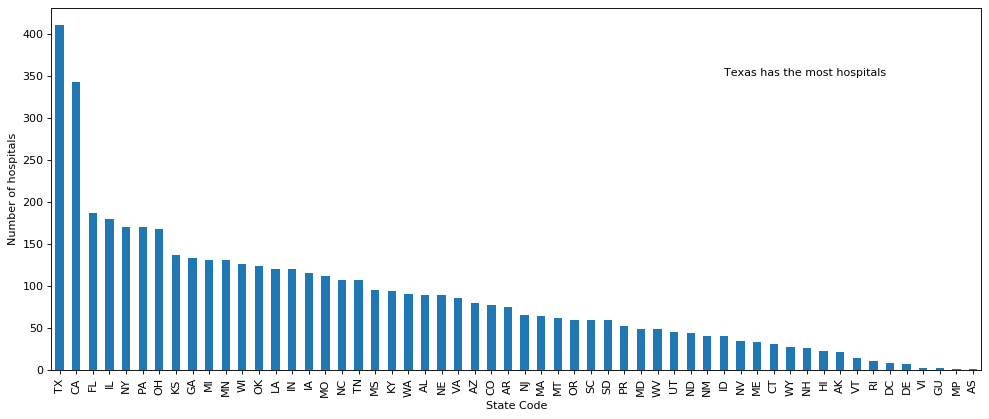

In [22]:
#Plotting the number of hospitals in each state
n_hosp_state=states_df['Hospital Name'].count()
states=df['State'].value_counts()

figure(figsize=(15, 6), dpi=80)
states.plot(kind='bar')
plt.annotate('Texas has the most hospitals',xy=(40,350))
plt.rcParams["font.size"] = "12"
plt.xlabel("State Code")
plt.ylabel("Number of hospitals")
plt.show()

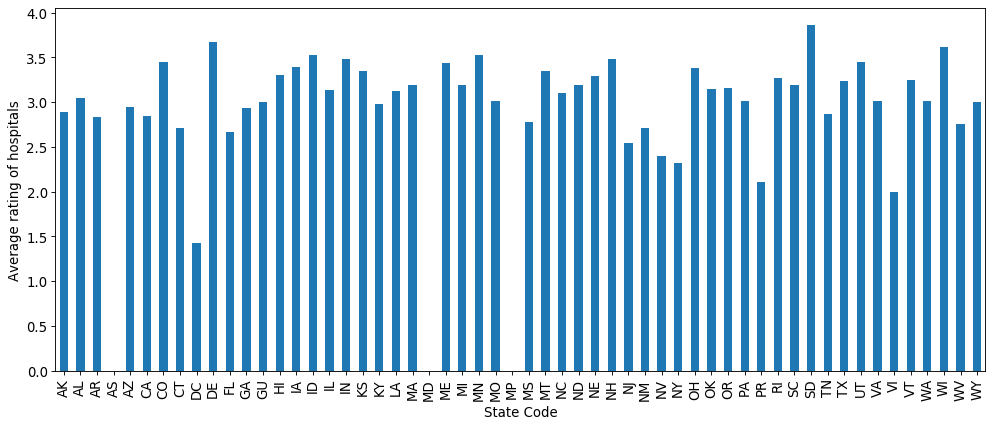

In [23]:
#Plotting the quality of hospitals in each state

all_states=df.groupby("State")
n_hosp_qual=all_states['Hospital overall rating'].mean()

figure(figsize=(15, 6), dpi=80)
n_hosp_qual.plot(kind='bar')
#plt.annotate('Texas has the most hospitals',xy=(40,350))
plt.rcParams["font.size"] = "12"
plt.xlabel("State Code")
plt.ylabel("Average rating of hospitals")
plt.show()


In [26]:
hosp_info=hosp_info.drop(columns=['Location']) 

In [27]:
hosp_info.head()
hosp_info['Location']=""

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Hosp_Owner_Code
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,GOVERNMENT - FEDERAL/STATE/COUNTY/DISTRICT,GOV_FSCD
1,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,PROPRIETARY,PRP
2,10032,WEDOWEE HOSPITAL,209 NORTH MAIN STREET,WEDOWEE,AL,36278,RANDOLPH,2563572111,Acute Care Hospitals,GOVERNMENT - FEDERAL/STATE/COUNTY/DISTRICT,GOV_FSCD
3,10095,HALE COUNTY HOSPITAL,508 GREEN STREET,GREENSBORO,AL,36744,HALE,3346243024,Acute Care Hospitals,GOVERNMENT - LOCAL,GOV_L
4,10131,CRESTWOOD MEDICAL CENTER,ONE HOSPITAL DR SE,HUNTSVILLE,AL,35801,MADISON,2568823100,Acute Care Hospitals,PROPRIETARY,PRP


In [29]:
locs=[]
for index, row in hosp_info.iterrows():
    location=row['Address']+','+row['City']+','+row['State']+'-'+str(row['ZIP Code'])
    locs.append(location)


In [32]:
hosp_info['Location']=locs
hosp_info.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Hosp_Owner_Code,Location
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,GOVERNMENT - FEDERAL/STATE/COUNTY/DISTRICT,GOV_FSCD,"2505 U S HIGHWAY 431 NORTH,BOAZ,AL-35957"
1,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,PROPRIETARY,PRP,"200 MED CENTER DRIVE,FORT PAYNE,AL-35968"
2,10032,WEDOWEE HOSPITAL,209 NORTH MAIN STREET,WEDOWEE,AL,36278,RANDOLPH,2563572111,Acute Care Hospitals,GOVERNMENT - FEDERAL/STATE/COUNTY/DISTRICT,GOV_FSCD,"209 NORTH MAIN STREET,WEDOWEE,AL-36278"
3,10095,HALE COUNTY HOSPITAL,508 GREEN STREET,GREENSBORO,AL,36744,HALE,3346243024,Acute Care Hospitals,GOVERNMENT - LOCAL,GOV_L,"508 GREEN STREET,GREENSBORO,AL-36744"
4,10131,CRESTWOOD MEDICAL CENTER,ONE HOSPITAL DR SE,HUNTSVILLE,AL,35801,MADISON,2568823100,Acute Care Hospitals,PROPRIETARY,PRP,"ONE HOSPITAL DR SE,HUNTSVILLE,AL-35801"


In [33]:
addresses=hosp_info[['Location']]

addresses

,Location
0,"2505 U S HIGHWAY 431 NORTH,BOAZ,AL-35957"
1,"200 MED CENTER DRIVE,FORT PAYNE,AL-35968"
2,"209 NORTH MAIN STREET,WEDOWEE,AL-36278"
3,"508 GREEN STREET,GREENSBORO,AL-36744"
4,"ONE HOSPITAL DR SE,HUNTSVILLE,AL-35801"
...,...
4807,"500 MEDICAL CENTER BLVD,WEBSTER,TX-77598"
4808,"475 W RIVER WOODS PKWY,GLENDALE,WI-53212"
4809,"159 HARTLEY WAY,PEARISBURG,VA-24134"
4810,"2520 VALLEY DRIVE,POINT PLEASANT,WV-25550"


In [34]:
base_url = "https://maps.googleapis.com/maps/api/geocode/json"
latitudes=[]
longitudes=[]
params = {"key": g_key}

for index, row in addresses.iterrows():
    address=row
    params['address'] = address
    try:
        my_geo = requests.get(base_url, params).json()
        lat = my_geo["results"][0]["geometry"]["location"]["lat"]
        lng = my_geo["results"][0]["geometry"]["location"]["lng"]

        latitudes.append(lat)

        longitudes.append(lng)
    except:
        print(f"Error locating address: {address} ")

print("End of Loop")





Error locating address: Location    BO. RINCON SECTOR LAS LOMAS  KM.3.1 CARR 14,CA...
Name: 286, dtype: object 
Error locating address: Location    AVE. PEDRO ALBIZU CAMPOS URB. LA HACIENDA,GUAY...
Name: 297, dtype: object 
Error locating address: Location    CARR.2 KM.1.4 AVE. SEVERIANO CUEVAS #18,AGUADI...
Name: 299, dtype: object 
Error locating address: Location    CARRETERA 129 KM.1 AVENIDA SAN LUIS,ARECIBO,PR...
Name: 300, dtype: object 
Error locating address: Location    AVE LAS CUMBRES ST 199KM 1 2,ALT DE SANTA,PR-969
Name: 319, dtype: object 
Error locating address: Location    3131 THOMASVILLE HWY BOX 40,MOULTRIE,GA-31768
Name: 769, dtype: object 
Error locating address: Location    701 PRINCETON AVENUE SOUTHWEST,BIRMINGHAM,AL-3...
Name: 1038, dtype: object 
Error locating address: Location    1018 SIXTH AVENUE PO BOX 997,WORTHINGTON,MN-56187
Name: 3184, dtype: object 
End of Loop


In [35]:
all_addr=pd.DataFrame({"Lat": latitudes,
                           "Lng" :longitudes
                      })
all_addr.head()


,Lat,Lng
0,34.221688,-86.160710
1,34.441975,-85.755014
2,33.310670,-85.485005
3,32.695544,-87.586908
4,34.720758,-86.574990


In [36]:
len(all_addr)

4804

In [37]:
locations=all_addr

figure_layout = {
    'width': '800px',
    'height': '500px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
gmaps.configure(api_key=g_key)
fig = gmaps.figure(layout=figure_layout)
#fig = gmaps.figure()

hosp_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(150, 0, 0, 0.4)',
    stroke_color='rgba(150, 0, 0, 0.4)', scale=2

)

fig.add_layer(hosp_layer)

fig

Figure(layout=FigureLayout(border='1px solid black', height='500px', margin='0 auto 0 auto', padding='1px', wi…